# Stroke Prediction

### Importing libraries and dataset

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download fedesoriano/stroke-prediction-dataset

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 25.2MB/s]


In [3]:
!unzip stroke-prediction-dataset.zip

Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [6]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Checking for null values

In [7]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Checking for Imbalance

0    4861
1     249
Name: stroke, dtype: int64


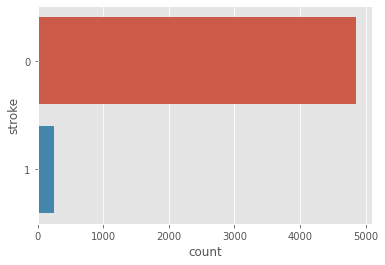

In [8]:
print(df['stroke'].value_counts())
sns.countplot(data = df, y = 'stroke')
plt.show()

### Exploring features

In [9]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [10]:
df.drop(['id'], axis=1, inplace=True)

In [11]:
countVar = [x for x in df.columns if x not in df.loc[:,df.dtypes == np.float].columns]

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


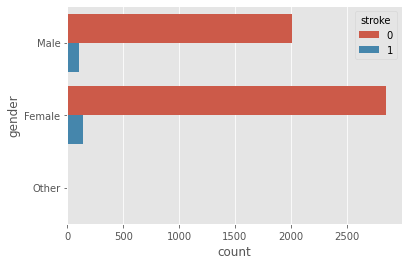

0    4612
1     498
Name: hypertension, dtype: int64


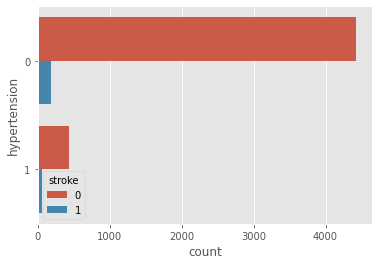

0    4834
1     276
Name: heart_disease, dtype: int64


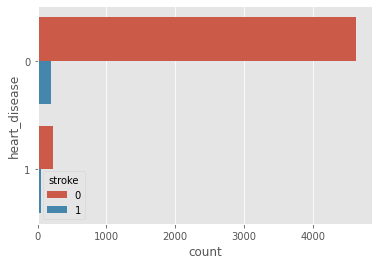

Yes    3353
No     1757
Name: ever_married, dtype: int64


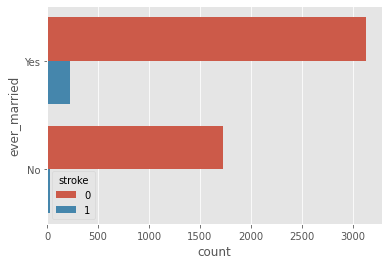

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


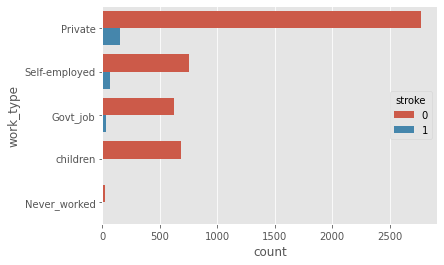

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


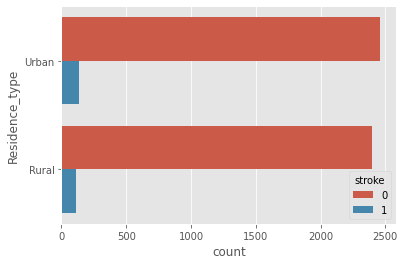

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


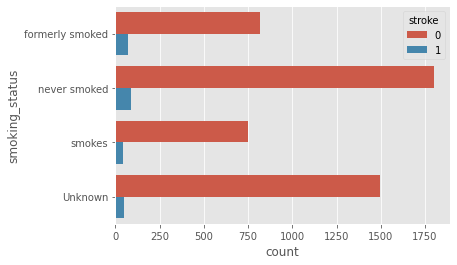

In [12]:
for variable in countVar:
    if variable == 'stroke':
        continue
    print(df[variable].value_counts())
    sns.countplot(data = df, y = variable, hue = 'stroke')
    plt.show()

In [13]:
ContinousVar = [x for x in df.columns if x in df.loc[:,df.dtypes == np.float].columns]

In [14]:
sc = StandardScaler()
new_df = df.copy()
new_df = new_df[ContinousVar]
scaled = sc.fit_transform(new_df)
scaled_df = pd.DataFrame(data = scaled, columns = new_df.columns)
scaled_df['stroke'] = df['stroke']

scaled_df_melt = pd.melt(scaled_df, id_vars = 'stroke')
scaled_df_melt.head()

,stroke,variable,value
0,1,age,1.051434
1,1,age,0.786070
2,1,age,1.626390
3,1,age,0.255342
4,1,age,1.582163


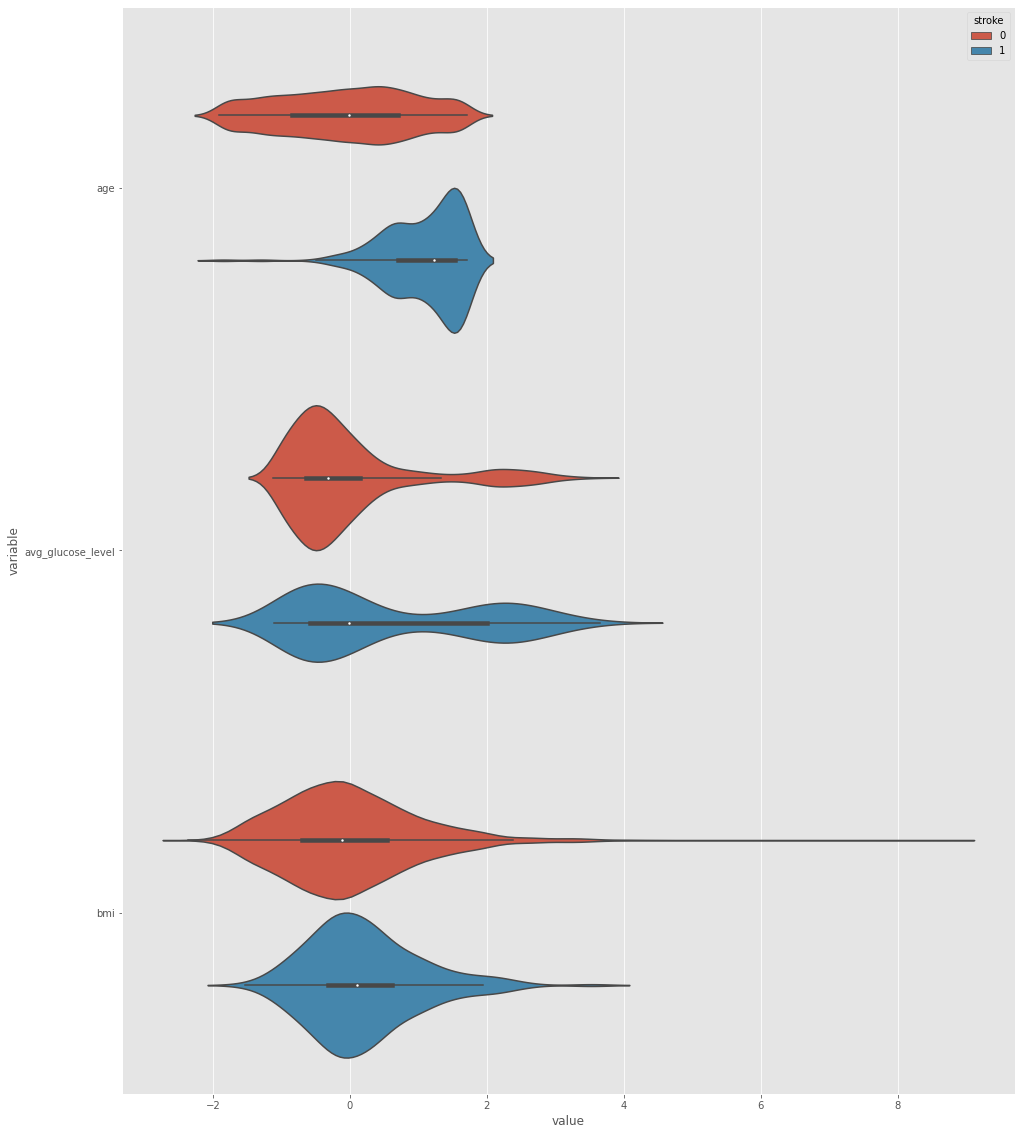

In [15]:
plt.figure(figsize=(16, 20))
sns.violinplot(x = 'value', y = 'variable', hue = 'stroke', data = scaled_df_melt)

### Imputation

In [16]:
mean_bmi_0 = df['bmi'][df['stroke'] == 0].mean()
mean_bmi_1 = df['bmi'][df['stroke'] == 1].mean()

In [17]:
df.loc[df['bmi'].isna() & df['stroke'] == 1, 'bmi'] = mean_bmi_1
df.fillna(mean_bmi_0, inplace = True)
#Try KNNImputer

In [18]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Oversampling using SMOTE

In [19]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [20]:
ct = ColumnTransformer(transformers = [('encoder1', OrdinalEncoder(), [0, 4, 6]), ('encoder2', OneHotEncoder(), [5, 9]),], remainder= 'passthrough')
X = ct.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
print('BEFORE OVERSAMPLING :')
print(f'# Label 0 = {sum(y_train==0)}')
print(f'# Label 1 = {sum(y_train==1)}')

sm = SMOTE()
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train.ravel())

print('AFTER OVERSAMPLING :')
print(f'Shape of X_train = {X_train_resample.shape}')
print(f'Shape of y_train = {y_train_resample.shape}')
print(f'# Label 0 = {sum(y_train_resample==0)}')
print(f'# Label 1 = {sum(y_train_resample==1)}')

BEFORE OVERSAMPLING :
# Label 0 = 3408
# Label 1 = 169
AFTER OVERSAMPLING :
Shape of X_train = (6816, 17)
Shape of y_train = (6816,)
# Label 0 = 3408
# Label 1 = 3408


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [24]:
X

array([[1.0, 1.0, 1.0, ..., 1, 228.69, 36.6],
       [0.0, 1.0, 0.0, ..., 0, 202.21, 30.47129186602871],
       [1.0, 1.0, 0.0, ..., 1, 105.92, 32.5],
       ...,
       [0.0, 1.0, 0.0, ..., 0, 82.99, 30.6],
       [1.0, 1.0, 0.0, ..., 0, 166.29, 25.6],
       [0.0, 1.0, 1.0, ..., 0, 85.28, 26.2]], dtype=object)

### Classification

In [25]:
X_train = X_train_resample
y_train = y_train_resample

In [26]:
CompleteSummary=[]
allClf = {}
allClf['Decision Tree'] = DecisionTreeClassifier(random_state = 10)
allClf['Random Forest'] = RandomForestClassifier(random_state = 10)
allClf['Logistic Regression'] = LogisticRegression(random_state=10)
allClf['XGBoost'] =  XGBClassifier(eval_metric= 'error', random_state=10)
allClf['Support Vector Classifier'] = SVC(random_state = 10, probability = True)
allClf['KNN'] = KNeighborsClassifier()

In [27]:
def fit_report_model(model_name, clf, CompleteSummary):
    clf=model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confmat = confusion_matrix(y_test, y_pred) 
    accuracies = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 15)   
    y_probs = clf.predict_proba(X_test)[:,1]
    fp_rate, tp_rate, thresholds = roc_curve(y_test, y_probs)
    auroc = auc(fp_rate, tp_rate)
    precision = precision_score(y_test, y_pred)  
    recall = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)  
    summary=[]
    print(model_name)
    summary.append(model_name)
    print('CONFUSION MATRIX :')
    ax = sns.heatmap(confmat, annot=True)
    ax.set_ylim([0,2])
    plt.show()
    print('ACCURACY SCORE :',accuracy_score(y_test, y_pred))
    summary.append(accuracy_score(y_test, y_pred))
    print('K-F VALIDATION MEAN ACCURACY :', accuracies.mean())
    summary.append(accuracies.mean())
    print('AUC :', auroc)
    summary.append(auroc)
    print('F1 :', f1)
    summary.append(f1)
    print('PRECISION :', precision)
    summary.append(precision)
    print('RECALL :', recall)
    summary.append(recall)
    CompleteSummary.append(summary)
    print('x'.center(50,'-'))

Decision Tree
CONFUSION MATRIX :


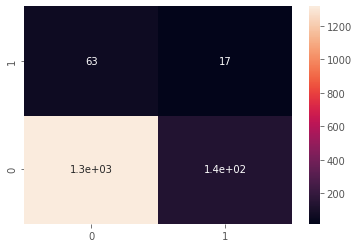

ACCURACY SCORE : 0.8695368558382257
K-F VALIDATION MEAN ACCURACY : 0.9290006615997807
AUC : 0.5591061596696489
F1 : 0.14529914529914528
PRECISION : 0.11038961038961038
RECALL : 0.2125
------------------------x-------------------------
Random Forest
CONFUSION MATRIX :


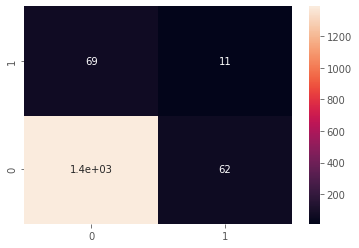

ACCURACY SCORE : 0.9145466405740378
K-F VALIDATION MEAN ACCURACY : 0.9664078359232543
AUC : 0.8022754645560908
F1 : 0.14379084967320263
PRECISION : 0.1506849315068493
RECALL : 0.1375
------------------------x-------------------------
Logistic Regression
CONFUSION MATRIX :


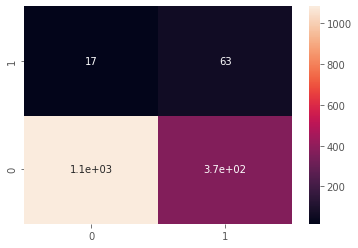

ACCURACY SCORE : 0.7475538160469667
K-F VALIDATION MEAN ACCURACY : 0.7877019896403158
AUC : 0.8421541637990365
F1 : 0.2456140350877193
PRECISION : 0.14549653579676675
RECALL : 0.7875
------------------------x-------------------------
XGBoost
CONFUSION MATRIX :


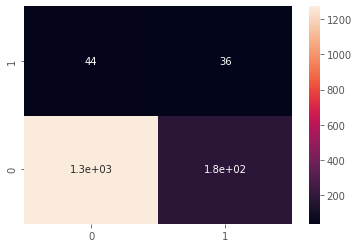

ACCURACY SCORE : 0.8538812785388128
K-F VALIDATION MEAN ACCURACY : 0.8998073292346419
AUC : 0.8254602546455609
F1 : 0.24324324324324323
PRECISION : 0.16666666666666666
RECALL : 0.45
------------------------x-------------------------
Support Vector Classifier
CONFUSION MATRIX :


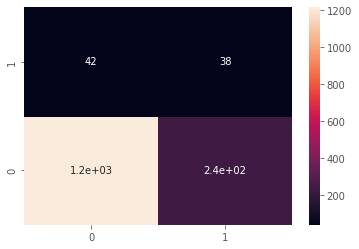

ACCURACY SCORE : 0.8186562296151337
K-F VALIDATION MEAN ACCURACY : 0.8978877216762678
AUC : 0.7698425671025466
F1 : 0.21468926553672313
PRECISION : 0.1386861313868613
RECALL : 0.475
------------------------x-------------------------
KNN
CONFUSION MATRIX :


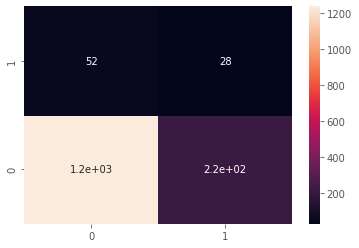

ACCURACY SCORE : 0.8258317025440313
K-F VALIDATION MEAN ACCURACY : 0.9188675348146714
AUC : 0.6600911906400551
F1 : 0.17337461300309598
PRECISION : 0.11522633744855967
RECALL : 0.35
------------------------x-------------------------


In [28]:
for model_name, model in allClf.items():
    fit_report_model(model_name, model, CompleteSummary)

In [29]:
summary_df = pd.DataFrame(CompleteSummary, columns= ['Model Name', 'Accuracy Score', 'K-F Valid Mean Accuracy', 'AUC', 'F1', 'Precision', 'Recall'])
summary_df.sort_values(by= ['F1', 'AUC'], inplace= True, ascending= False)
summary_df

,Model Name,Accuracy Score,K-F Valid Mean Accuracy,AUC,F1,Precision,Recall
2,Logistic Regression,0.747554,0.787702,0.842154,0.245614,0.145497,0.7875
3,XGBoost,0.853881,0.899807,0.825460,0.243243,0.166667,0.4500
4,Support Vector Classifier,0.818656,0.897888,0.769843,0.214689,0.138686,0.4750
5,KNN,0.825832,0.918868,0.660091,0.173375,0.115226,0.3500
0,Decision Tree,0.869537,0.929001,0.559106,0.145299,0.110390,0.2125
1,Random Forest,0.914547,0.966408,0.802275,0.143791,0.150685,0.1375


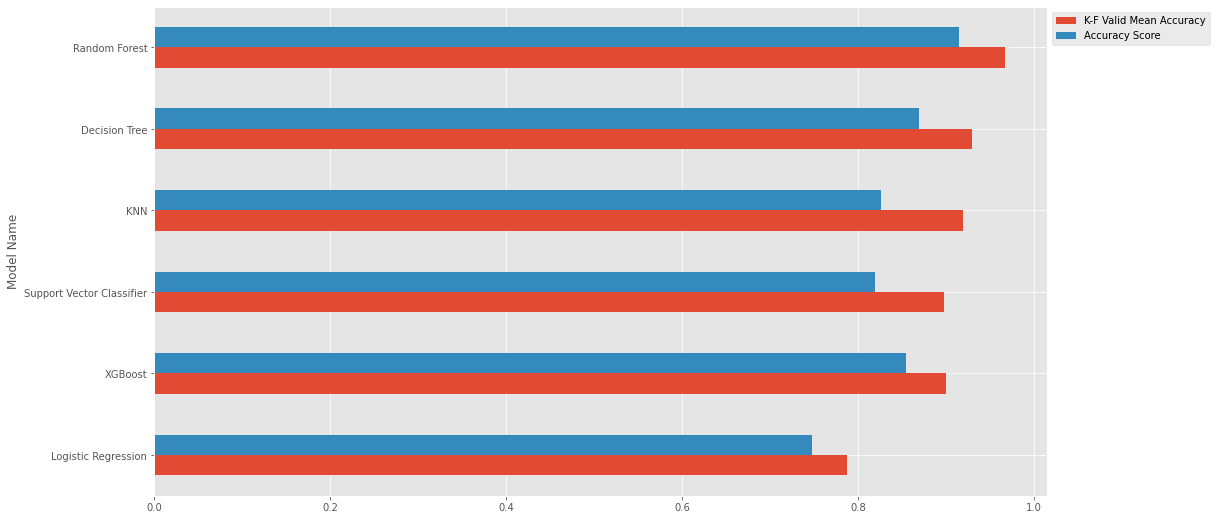

In [30]:
ax = summary_df.plot.barh(x = 'Model Name', y={'Accuracy Score', 'K-F Valid Mean Accuracy'},figsize=(16,9))
ax.legend(bbox_to_anchor=(1, 1));

*Focus on better recall

<hr>